### Import libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Getting to know the data

In [2]:
data = np.load('inputs/proyecto_training_data.npy')

In [3]:
print(data.shape)
n_train = int(np.ceil(data.shape[0]*0.8))

(1460, 6)


In [4]:
#np.random.seed([1,2])
#np.random.shuffle(data)
train, test = data[:n_train, :], data[n_train:, :] 
assert (train.shape[0] + test.shape[0]) == data.shape[0]

In [5]:
data

array([[2.08500e+05, 7.00000e+00, 8.56000e+02, 8.00000e+00, 2.00300e+03,
        6.50000e+01],
       [1.81500e+05, 6.00000e+00, 1.26200e+03, 6.00000e+00, 1.97600e+03,
        8.00000e+01],
       [2.23500e+05, 7.00000e+00, 9.20000e+02, 6.00000e+00, 2.00100e+03,
        6.80000e+01],
       ...,
       [2.66500e+05, 7.00000e+00, 1.18800e+03, 9.00000e+00, 1.94100e+03,
        6.60000e+01],
       [1.42125e+05, 5.00000e+00, 1.07800e+03, 5.00000e+00, 1.95000e+03,
        6.80000e+01],
       [1.47500e+05, 5.00000e+00, 1.25600e+03, 6.00000e+00, 1.96500e+03,
        7.50000e+01]])

In [6]:
ds_train = pd.DataFrame(train, columns = ['SalePrice', 'OverallQual', '1stFlrSF', 'TotRmsAbvGrd', 'YearBuilt', 'LotFrontage'])
ds_train.head()

,SalePrice,OverallQual,1stFlrSF,TotRmsAbvGrd,YearBuilt,LotFrontage
0,208500.0,7.0,856.0,8.0,2003.0,65.0
1,181500.0,6.0,1262.0,6.0,1976.0,80.0
2,223500.0,7.0,920.0,6.0,2001.0,68.0
3,140000.0,7.0,961.0,7.0,1915.0,60.0
4,250000.0,8.0,1145.0,9.0,2000.0,84.0


In [7]:
stats = ds_train.describe().loc[['mean', 'max', 'min', 'std']]

In [8]:
stats = stats.append((ds_train.max() - abs(ds_train.min())).rename('range'))
stats

,SalePrice,OverallQual,1stFlrSF,TotRmsAbvGrd,YearBuilt,LotFrontage
mean,180590.277397,6.101027,1156.323630,6.485445,1971.451199,69.946985
max,755000.000000,10.000000,3228.000000,14.000000,2010.000000,313.000000
min,34900.000000,1.000000,334.000000,2.000000,1875.000000,21.000000
std,78815.697902,1.378025,373.780374,1.609141,29.951707,23.478161
range,720100.000000,9.000000,2894.000000,12.000000,135.000000,292.000000


### Visualizing the data

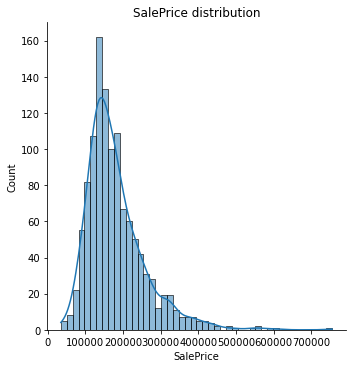

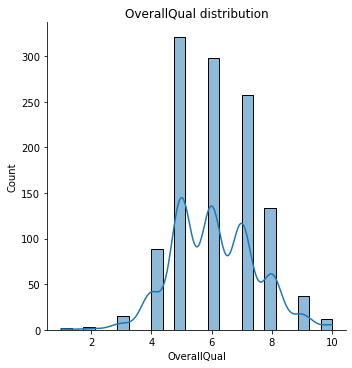

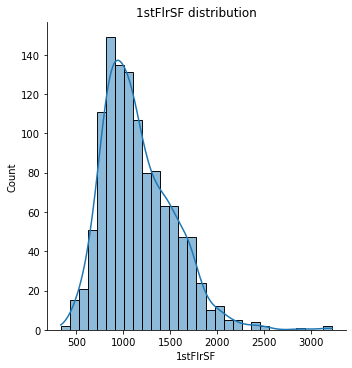

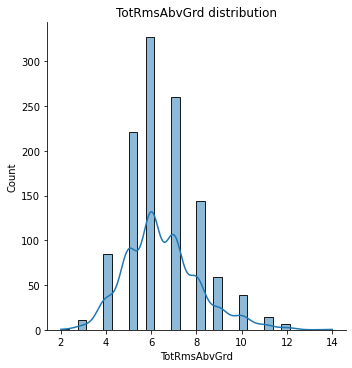

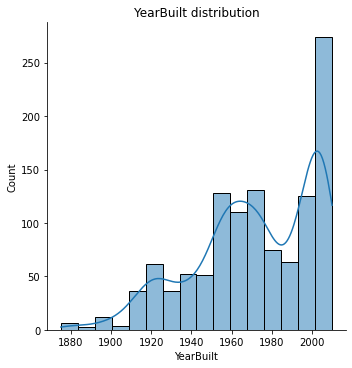

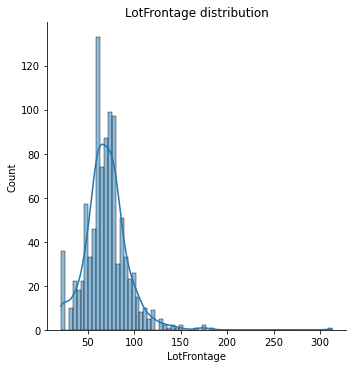

In [84]:
for col in ds_train.columns[0:]:
    #sns.distplot(a = ds_train[col], kde = 'True') #distplot is deprecated
    sns.displot(data = ds_train, x = col, kde = True)
    plt.title('{} distribution'.format(col))
    plt.show()

#### Correlation Analysis

In [105]:
response = 'SalePrice'
regressors = ds_train.columns[1:]

In [106]:
corr_values = ds_train.corr()[response].iloc[1:].round(4).sort_values(ascending = False)
corr_values

OverallQual     0.7940
1stFlrSF        0.6163
TotRmsAbvGrd    0.5647
YearBuilt       0.5342
LotFrontage     0.3633
Name: SalePrice, dtype: float64

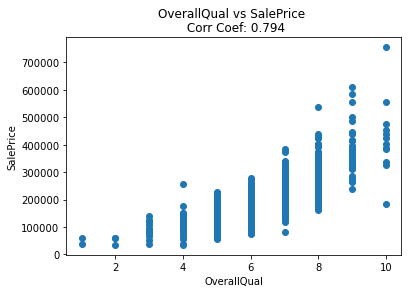

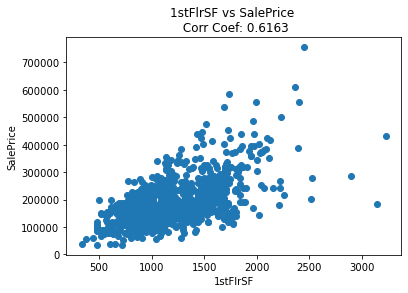

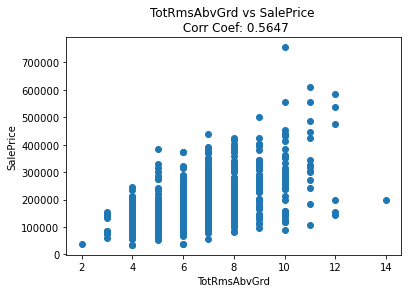

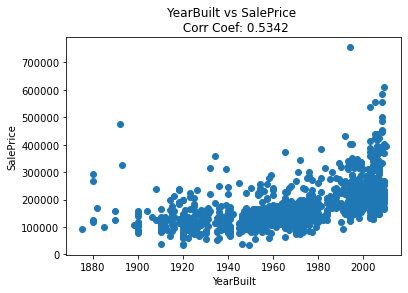

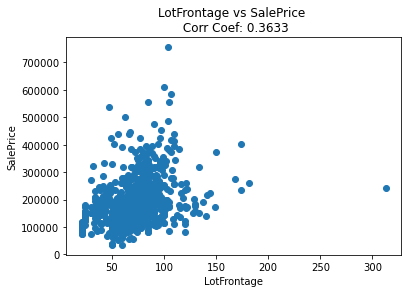

In [107]:
for x in regressors:
    plt.scatter(x = ds_train[x], y = ds_train[response])
    plt.title('{} vs {} \n Corr Coef: {}'.format(x, response, corr_values[x]))
    plt.xlabel(x)
    plt.ylabel(response)
    plt.show()

In [109]:
#select top 2 regressors based on highest correlation coefficient
regressors = list(corr_values.index[0:2])
regressors

['OverallQual', '1stFlrSF']

### Models

In [480]:
def trainModel(X, Y, epochs = 100, print_error_every = 10, lr = 0.001):
    #initializing data
    observations = np.vstack((X, np.ones_like(X))).T
    errors = []
    model_params = dict()
    parameters = np.ones((2,)) #np.ones((2,)) #np.array([0, 0]) np.random.rand(2)
    
    for i in range(1, epochs + 1):
        #estimating values
        yhat = np.matmul(observations, parameters) #np.dot(observations, parameters)
        #print(yhat)
        #print(Y)
        #print(Y-yhat)
        
        #calculating errors
        error = (1/2) * np.mean(np.power((Y - yhat), 2)) #mean squared error (MSE)
        errors.append(error)
        #print(errors)
        #print('-----------')

        #calculating gradients
        gradients = np.mean(np.vstack(((yhat - Y),(yhat - Y))).T * observations, axis = 0)
        parameters = parameters - (lr * gradients)
        model_params[i] = parameters
        #print(gradients)
        #print(parameters)
        #print('*******')
        
        if i % print_error_every == 0:
            print("Epoch {}/{}, error value: {}".format(i, epochs, error))
            pass
    
    return model_params, errors

In [496]:
def plotError(errors):
    plt.plot(range(0,len(errors)), errors)
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.title("Losses")
    plt.show()
    return

In [498]:
def visualizeModel(X, Y, model_params, n = 25):
    for i in range(1, len(model_params) + 1):
        if i % n == 0:
            plt.scatter(x = X, y = Y)
            yhat = np.matmul(np.vstack((X, np.ones_like(X))).T, model_params[i])
            plt.plot(X, yhat)
            plt.show()
    return

### Train Variables

#### OverallQual

In [502]:
model_params, errors = trainModel(ds_train[regressors[0]].values, ds_train[response].values, epochs = 100,  print_error_every = 10)

Epoch 10/100, error value: 10022195532.475634
Epoch 20/100, error value: 5202005031.387338
Epoch 30/100, error value: 3074554751.6343718
Epoch 40/100, error value: 2135505534.2733722
Epoch 50/100, error value: 1720939614.5337248
Epoch 60/100, error value: 1537846738.8062172
Epoch 70/100, error value: 1456911179.5728087
Epoch 80/100, error value: 1421061359.3148305
Epoch 90/100, error value: 1405109584.072643
Epoch 100/100, error value: 1397939638.7650902


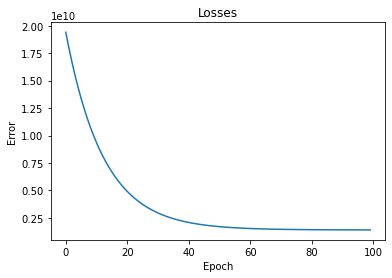

In [503]:
plotError(errors)

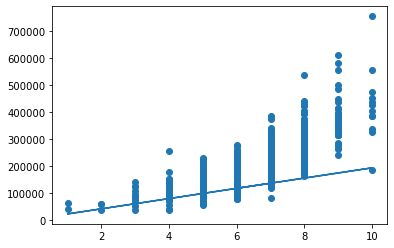

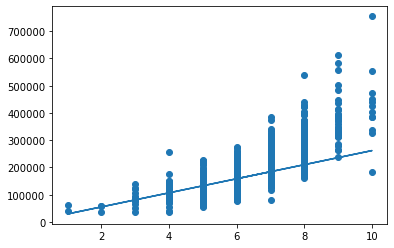

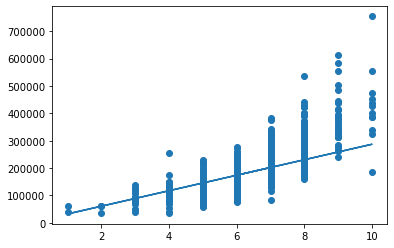

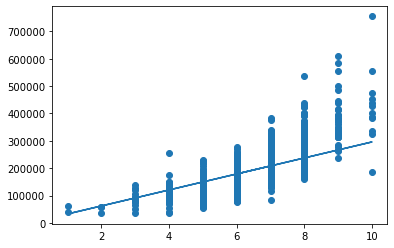

In [504]:
visualizeModel(ds_train[regressors[0]].values, ds_train[response].values, model_params, n = 25)

### 1stFlrSf

In [508]:
model_params, errors = trainModel(ds_train[regressors[1]].values, ds_train[response].values, epochs = 100,  print_error_every = 10, lr = 0.000001)

Epoch 10/100, error value: 1968117942.5819402
Epoch 20/100, error value: 1968090066.179731
Epoch 30/100, error value: 1968089984.0007734
Epoch 40/100, error value: 1968089901.8321683
Epoch 50/100, error value: 1968089819.6637185
Epoch 60/100, error value: 1968089737.4954236
Epoch 70/100, error value: 1968089655.3272839
Epoch 80/100, error value: 1968089573.1593
Epoch 90/100, error value: 1968089490.9914718
Epoch 100/100, error value: 1968089408.8237982


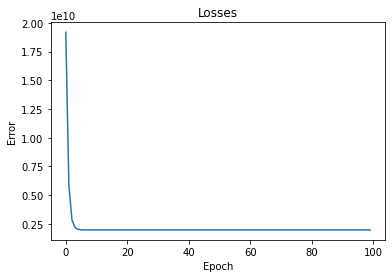

In [509]:
plotError(errors)

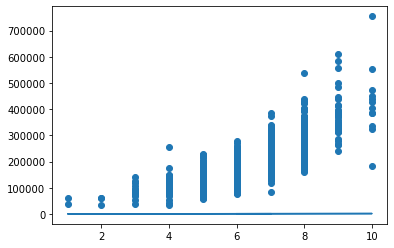

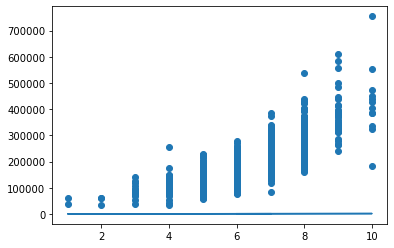

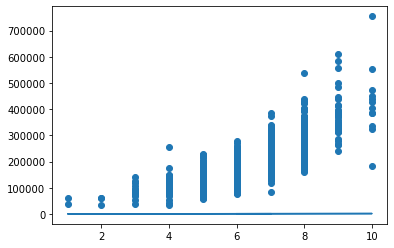

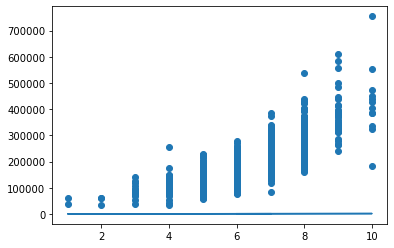

In [510]:
visualizeModel(ds_train[regressors[0]].values, ds_train[response].values, model_params, n = 25)